# Analyse dN/dS (RELAX output)

## Run HyPhy in parallel
```bash

# Run RELAX with branches with ecosystem gains as foreground
nohup ~/mambaforge/envs/hgt_analyses/bin/python code/run_hyphy_parallel.py -i data/inferences/dn_ds/map.aln_treefile_input_filepaths.fg.tsv  -o data/inferences/dn_ds/relax/output_fg -a relax -r2 2>&1 > data/nohup_relax_fg_dnds.log & disown
```

## Analyse HyPhy output

In [1]:
import os
import sys
import json
import importlib
from scipy.stats import chi2, false_discovery_control
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# set global pyplot font to be serif
plt.rcParams['font.family'] = 'serif'

# double all font sizes
plt.rcParams['font.size'] = 2 * plt.rcParams['font.size']

# Add the code directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'code'))

# Reload the module to ensure any changes are reflected
if 'analyse_hyphy_output' in sys.modules:
    importlib.reload(sys.modules['analyse_hyphy_output'])
else:
    import analyse_hyphy_output as aho

data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
dnds_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'inferences', 'dn_ds')
relax_dir = os.path.join(dnds_dir, 'relax')
plots_dir = os.path.join(data_dir, 'plots')

def get_likelihood_ratio(ll1, ll2):
    return 2 * np.abs(ll1 - ll2)
def get_p_value(ll1, ll2, df=1):
    lr = get_likelihood_ratio(ll1, ll2)
    return chi2.sf(lr, df)


In [2]:
def extract_and_process_output_relax(relax_dir, sub_dir, prefix):
    dir_path = os.path.join(relax_dir, sub_dir)
    flat_df = aho.extract_hyphy_output_relax(dir_path, max_threads=2)
    flat_df.to_csv(os.path.join(relax_dir, f"{sub_dir}_out_flat.csv"), index=False)
    flat_df.set_index("OG", inplace=True)
    flat_df.columns = [f"{prefix}|{col}" for col in flat_df.columns]
    return flat_df

relax_flat_fg_df = extract_and_process_output_relax(relax_dir, 'output_fg', 'fg')

Extracting data:   0%|          | 0/3228 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 3228/3228 [00:03<00:00, 1056.79it/s]


Error while reading JSON for 0 OGs: []
Exceptions while reading JSON for 0 OGs: {}


In [3]:
relax_flat_fg_df

,fg|RELAX alternative|Log Likelihood,fg|RELAX alternative|Reference|0|omega,fg|RELAX alternative|Reference|0|proportion,fg|RELAX alternative|Reference|1|omega,fg|RELAX alternative|Reference|1|proportion,fg|RELAX alternative|Reference|2|omega,fg|RELAX alternative|Reference|2|proportion,fg|RELAX alternative|Test|0|omega,fg|RELAX alternative|Test|0|proportion,fg|RELAX alternative|Test|1|omega,...,fg|RELAX null|Reference|2|proportion,fg|RELAX null|Test|0|omega,fg|RELAX null|Test|0|proportion,fg|RELAX null|Test|1|omega,fg|RELAX null|Test|1|proportion,fg|RELAX null|Test|2|omega,fg|RELAX null|Test|2|proportion,fg|RELAX test|p-value,fg|RELAX test|LRT,fg|RELAX test|K
OG,,,,,,,,,,,,,,,,,,,,,
D3SSF,-1036.966295,3.537958e-03,0.569150,0.873598,0.430850,9.988603e+00,0.000000,6.024313e-03,0.569150,0.884801,...,0.000000,5.339995e-03,0.566617,0.874800,0.433383,6.676867e+00,0.000000,8.934683e-01,1.793372e-02,0.905699
D3RI7,-841.680224,7.860058e-04,0.116451,0.012649,0.763096,1.000000e+00,0.120454,1.392123e-03,0.116451,0.017940,...,0.119966,8.815341e-04,0.119679,0.015216,0.760354,1.000000e+00,0.119966,8.161065e-01,5.408212e-02,0.920037
D3V98,-1056.861695,0.000000e+00,0.342517,0.070217,0.570276,2.179078e+02,0.087207,0.000000e+00,0.342517,0.078693,...,0.087429,0.000000e+00,0.344330,0.076940,0.568241,1.729802e+02,0.087429,8.584309e-01,3.181653e-02,0.957097
D1CTF,-962.131404,2.440825e-02,0.377387,0.506955,0.482206,1.219885e+01,0.140408,1.401319e-04,0.377387,0.197214,...,0.120172,3.858568e-04,0.373039,0.216747,0.506789,2.348696e+02,0.120172,1.530562e-01,2.041524e+00,2.389799
D3W3R,-754.853454,5.613358e-03,0.628768,0.339669,0.316878,9.999999e+09,0.054354,5.613358e-03,0.628768,0.339669,...,0.054354,5.613358e-03,0.628768,0.339669,0.316878,9.999999e+09,0.054354,9.996189e-01,2.281406e-07,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COG1185,-133433.298169,1.261103e-05,0.776456,0.469075,0.199068,7.940109e+03,0.024475,2.542873e-09,0.776456,0.265012,...,0.025863,1.264786e-05,0.754316,0.249325,0.219821,8.048166e+03,0.025863,3.156256e-06,2.171914e+01,1.754284
COG0046,-13415.338758,3.682473e-03,0.632521,0.462034,0.311623,9.999999e+09,0.055855,3.745944e-03,0.632521,0.463123,...,0.055855,3.741448e-03,0.632522,0.462957,0.311623,9.999999e+09,0.055855,8.978436e-01,1.648295e-02,0.996951
COG0164,-47990.756331,1.352856e-05,0.752159,0.256667,0.206960,3.156048e+04,0.040881,4.687432e-04,0.752159,0.394593,...,0.039516,2.562349e-05,0.733961,0.339414,0.226522,2.775711e+04,0.039516,7.385006e-07,2.451196e+01,0.683762


/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


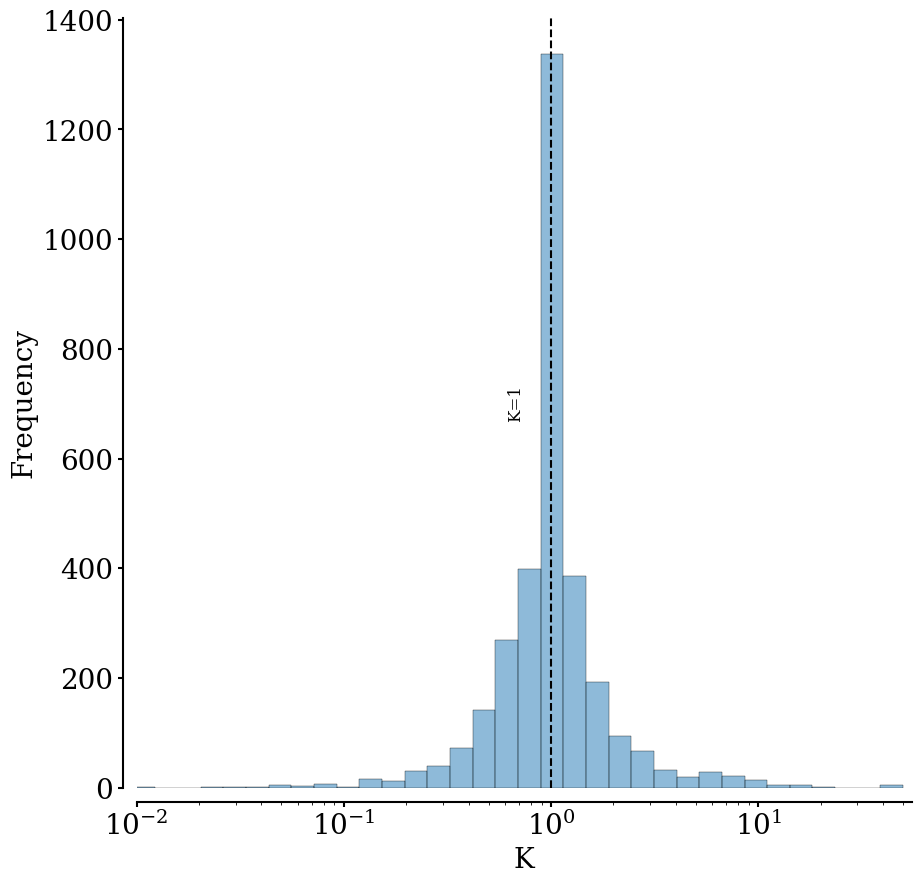

In [4]:
# plot histogram of 'fg|RELAX test|K' values, on log-log scale using seaborn
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(relax_flat_fg_df['fg|RELAX test|K'], bins=200, kde=True,
             log_scale=(True, False),
             ax=ax)
# K=1 line
ax.axvline(1, color='black', linestyle='--')
# annotate K=1 line with vertical text aligned left and centered
ax.annotate('K=1', 
            # position text based on axis coordinates
            xy=(0.5, 0.5),
            xycoords='axes fraction',
            fontsize=12, color='black', rotation=90,
            va='center', ha='right',
            )
ax.set_xlabel('K')
ax.set_ylabel('Frequency')
# Tufte style
# top and right spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# left and bottom spines thicker
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
# ticks thicker
ax.tick_params(width=1.5)
# spine bounds = data bounds
ax.set_xlim(left=0.01, right=relax_flat_fg_df['fg|RELAX test|K'].max() * 1.1)
# ax.set_ylim(bottom=0.01, top=relax_flat_fg_df['fg|RELAX test|K'].values.max() * 1.1)
# let axes breathe by moving them away from the data
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

plt.show()

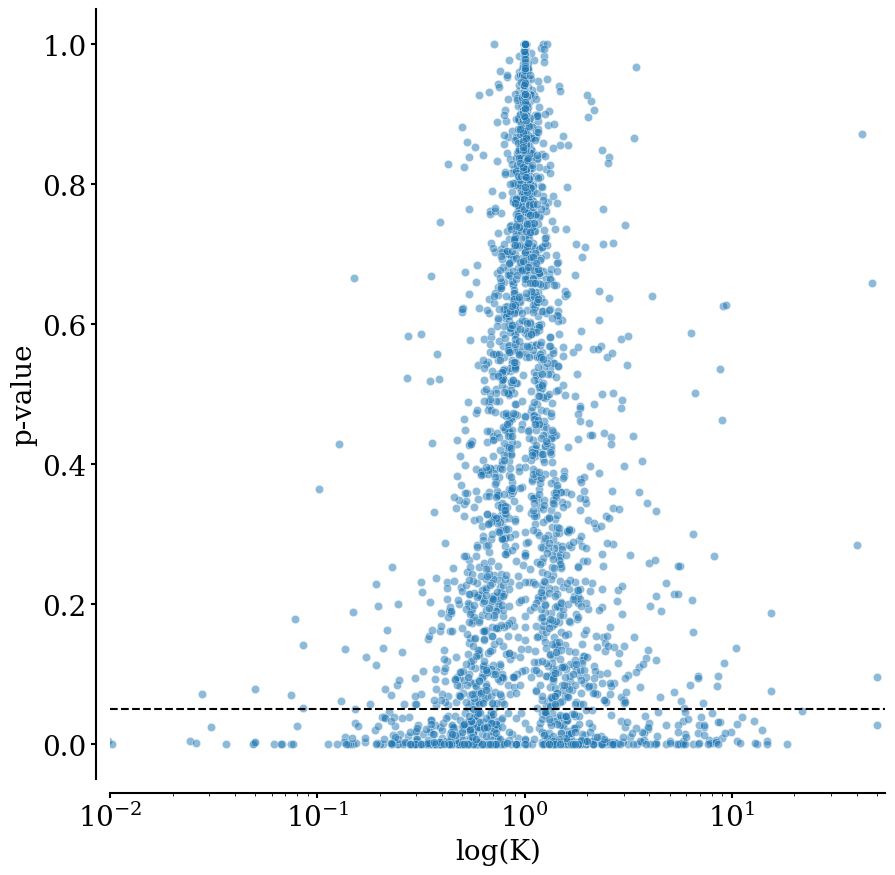

In [5]:
# plot scatter plot of K vs p-value

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=relax_flat_fg_df, x='fg|RELAX test|K', y='fg|RELAX test|p-value', ax=ax, alpha=0.5)
# p=0.05 line
ax.axhline(0.05, color='black', linestyle='--')
# annotate p=0.05 line with vertical text aligned left and centered
# ax.annotate('p=0.05', 
#             # position text based on axis coordinates
#             xy=(0.5, 0.5),
#             xycoords='axes fraction',
#             fontsize=12, color='black', rotation=90,
#             va='center', ha='right',
#             )
ax.set_xscale('log')
ax.set_xlabel('log(K)')
ax.set_ylabel('p-value')
# Tufte style
# top and right spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# left and bottom spines thicker
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
# ticks thicker
ax.tick_params(width=1.5)
# spine bounds = data bounds
ax.set_xlim(left=0.01, right=relax_flat_fg_df['fg|RELAX test|K'].max() * 1.1)
# ax.set_ylim(bottom=0.01, top=1.1)
# let axes breathe by moving them away from the data
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.show()

In [6]:
# print percentage of OGs with significant relaxation/intensification on branches with EG
print(f'Total number of OGs with significant relaxation/intensification on branches with EG: {len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05])}, out of {len(relax_flat_fg_df)}. That is {len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05]) / len(relax_flat_fg_df) * 100:.2f}%')
# percentage of OGs with significant relaxation (K < 1) on branches with EG
print(f'Relaxation\t (K < 1): {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)])}. That is {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)]) / len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05]) * 100:.2f}% or {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)]) / len(relax_flat_fg_df) * 100:.2f}% of all OGs')
# percentage of OGs with significant intensification (K > 1) on branches with EG
print(f'Intensification\t (K > 1): {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)])}. That is {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)]) / len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05]) * 100:.2f}% or {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)]) / len(relax_flat_fg_df) * 100:.2f}% of all OGs')

# perform FDR correction on p-values
relax_flat_fg_df['fg|RELAX test|p-value FDR'] = false_discovery_control(relax_flat_fg_df['fg|RELAX test|p-value'])
# print percentage of OGs with significant relaxation/intensification on branches with EG after FDR correction
print(f'\nAfter FDR correction:')
print(f'Total number of OGs with significant relaxation/intensification on branches with EG: {len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05])}, out of {len(relax_flat_fg_df)}. That is {len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05]) / len(relax_flat_fg_df) * 100:.2f}%')
# percentage of OGs with significant relaxation (K < 1) on branches with EG after FDR correction
print(f'Relaxation\t (K < 1): {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)])}. That is {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)]) / len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05]) * 100:.2f}% or {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)]) / len(relax_flat_fg_df) * 100:.2f}% of all OGs')
# percentage of OGs with significant intensification (K > 1) on branches with EG after FDR correction
print(f'Intensification\t (K > 1): {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)])}. That is {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)]) / len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05]) * 100:.2f}% or {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)]) / len(relax_flat_fg_df) * 100:.2f}% of all OGs')

# write out list of OGs with significant relaxation after FDR correction
relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)].index.to_series().to_csv(os.path.join(relax_dir, 'relaxation_fg_eg_ogs.csv'), index=False, header=False)
# write out list of OGs with significant intensification after FDR correction
relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)].index.to_series().to_csv(os.path.join(relax_dir, 'intensification_fg_eg_ogs.csv'), index=False, header=False)

Total number of OGs with significant relaxation/intensification on branches with EG: 564, out of 3228. That is 17.47%
Relaxation	 (K < 1): 327. That is 57.98% or 10.13% of all OGs
Intensification	 (K > 1): 234. That is 41.49% or 7.25% of all OGs

After FDR correction:
Total number of OGs with significant relaxation/intensification on branches with EG: 263, out of 3228. That is 8.15%
Relaxation	 (K < 1): 164. That is 62.36% or 5.08% of all OGs
Intensification	 (K > 1): 98. That is 37.26% or 3.04% of all OGs


/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


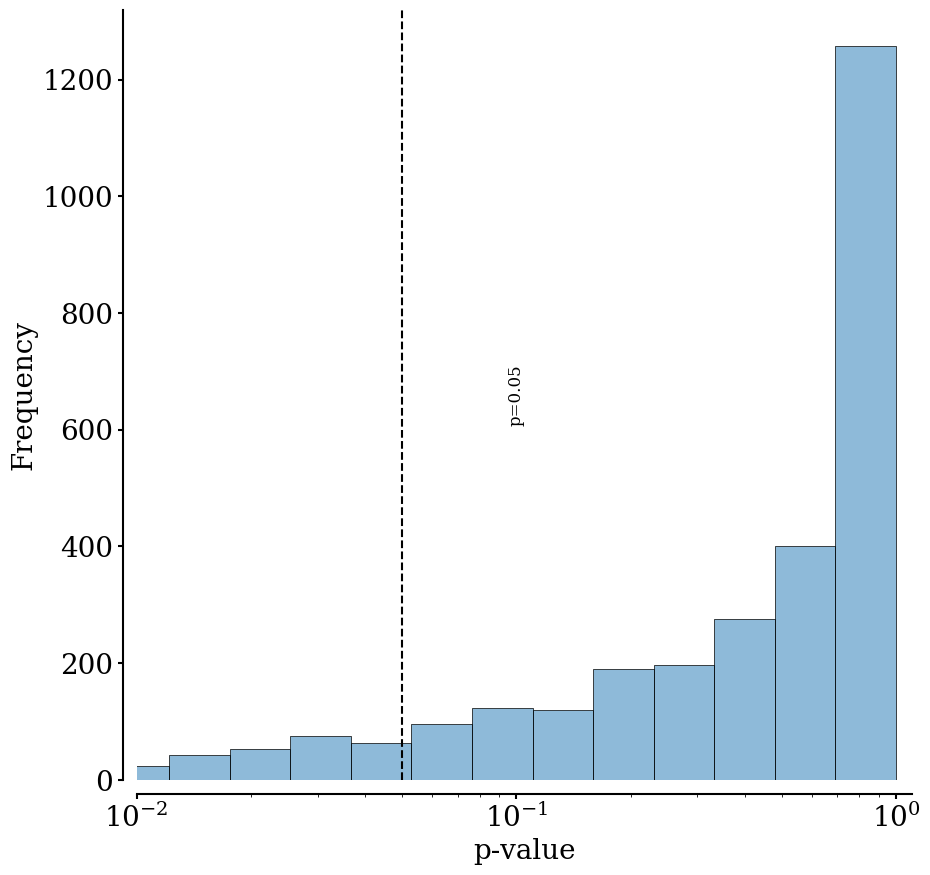

/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


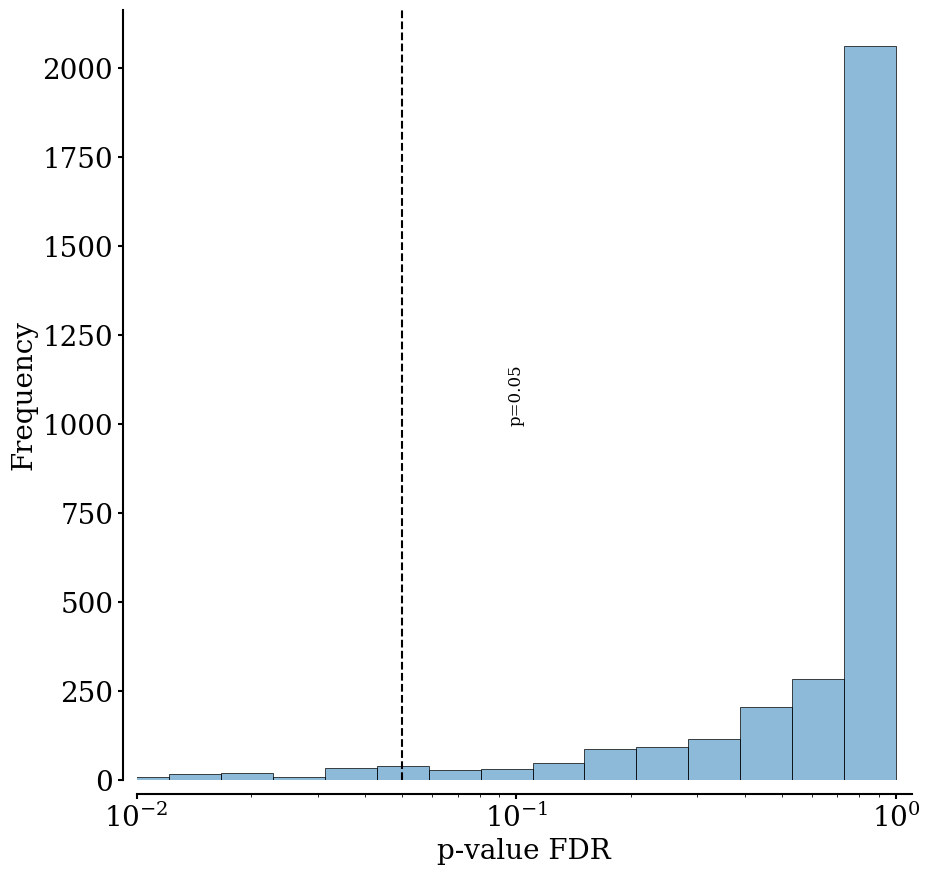

In [7]:
# plot the histogram of the p-values
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(relax_flat_fg_df['fg|RELAX test|p-value'], bins=100, kde=True,
             log_scale=(True, False), ax=ax)
# p=0.05 line
ax.axvline(0.05, color='black', linestyle='--')
# annotate p=0.05 line with vertical text aligned left and centered
ax.annotate('p=0.05', 
            # position text based on axis coordinates
            xy=(0.5, 0.5),
            xycoords='axes fraction',
            fontsize=12, color='black', rotation=90,
            va='center', ha='right',
            )
ax.set_xlabel('p-value')
ax.set_ylabel('Frequency')
# Tufte style
# top and right spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# left and bottom spines thicker
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
# ticks thicker
ax.tick_params(width=1.5)
# spine bounds = data bounds
ax.set_xlim(left=0.01, right=relax_flat_fg_df['fg|RELAX test|p-value'].max() * 1.1)
# ax.set_ylim(bottom=0.01, top=relax_flat_fg_df['fg|RELAX test|p-value'].values.max() * 1.1)
# let axes breathe by moving them away from the data
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.show()

# also FDR corrected p-values
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(relax_flat_fg_df['fg|RELAX test|p-value FDR'], bins=100, kde=True,
             log_scale=(True, False), ax=ax)
# p=0.05 line
ax.axvline(0.05, color='black', linestyle='--')
# annotate p=0.05 line with vertical text aligned left and centered
ax.annotate('p=0.05', 
            # position text based on axis coordinates
            xy=(0.5, 0.5),
            xycoords='axes fraction',
            fontsize=12, color='black', rotation=90,
            va='center', ha='right',
            )
ax.set_xlabel('p-value FDR')
ax.set_ylabel('Frequency')
# Tufte style
# top and right spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# left and bottom spines thicker
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
# ticks thicker
ax.tick_params(width=1.5)
# spine bounds = data bounds
ax.set_xlim(left=0.01, right=relax_flat_fg_df['fg|RELAX test|p-value FDR'].max() * 1.1)
# ax.set_ylim(bottom=0.01, top=relax_flat_fg_df['fg|RELAX test|p-value FDR'].values.max() * 1.1)
# let axes breathe by moving them away from the data
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.show()

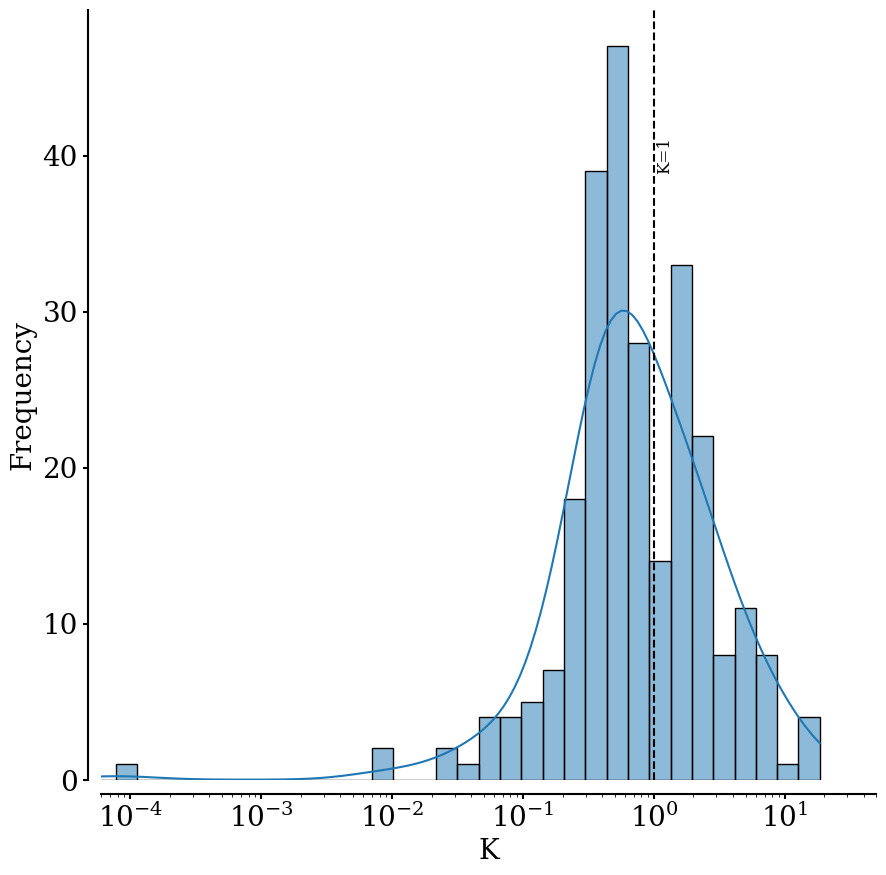

Median K for significant p-values (FDR < 0.05): 0.61
Total number of OGs with significant relaxation/intensification on branches with EG: 263, out of 3228. That is 8.15%
K > 1: 98. That is 37.26%
K < 1: 164. That is 62.36%
K = 1: 1. That is 0.38%
OGs with K=1: ['COG2996']


In [8]:
# same hist but only if p-value FDR is significant
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(relax_flat_fg_df[relax_flat_fg_df['fg|RELAX test|p-value FDR'] < 0.05]['fg|RELAX test|K'], bins=50, kde=True,
             alpha=0.5,
             log_scale=(True, False), ax=ax)
# K=1 line
ax.axvline(1, color='black', linestyle='--')
# annotate K=1 line with vertical text aligned left and centered
ax.annotate('K=1', 
            # position text based on axis coordinates
            xy=(1.4, 40),
            xycoords='data',
            fontsize=12, color='black', rotation=90,
            va='center', ha='right',
            )
ax.set_xlabel('K')
ax.set_ylabel('Frequency')
# Tufte style
# top and right spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# left and bottom spines thicker
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
# ticks thicker
ax.tick_params(width=1.5)
# spine bounds = data bounds
ax.set_xlim(left=6e-5, 
            right=relax_flat_fg_df['fg|RELAX test|K'].max())
# ax.set_ylim(bottom=0.01, top=relax_flat_fg_df['fg|RELAX test|K'].values.max() * 1.1)
# let axes breathe by moving them away from the data
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

plt.savefig(os.path.join(plots_dir, 'hist_relax_fg_K_significant.png'),
                        dpi=300, bbox_inches='tight')

plt.show()

# print median value of K for significant p-values
median_K = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX test|p-value FDR'] < 0.05]['fg|RELAX test|K'].median()
print(f'Median K for significant p-values (FDR < 0.05): {median_K:.2f}')

# print how many are higher or lower than 1
print(f'Total number of OGs with significant relaxation/intensification on branches with EG: {len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05])}, out of {len(relax_flat_fg_df)}. That is {len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05]) / len(relax_flat_fg_df) * 100:.2f}%')
print(f'K > 1: {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)])}. That is {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)]) / len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05]) * 100:.2f}%')
print(f'K < 1: {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)])}. That is {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)]) / len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05]) * 100:.2f}%')
print(f'K = 1: {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] == 1)])}. That is {len(relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] == 1)]) / len(relax_flat_fg_df[relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05]) * 100:.2f}%')
# print the OG IDs with K=1
print(f'OGs with K=1: {relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] == 1)].index.tolist()}')

In [9]:
# based COG fn categories analysis notebook:
# read in map of cog categories of gene families
cog_map_df = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'filtered', 'map.COG_category_gene_families.tsv'), sep='\t', header=0)
# this is now a df with columns: 'COG_category_name', 'gene_families' where 'gene_families' is a string that is a comma-separated list of OG IDs
# prepare a map of OGs to COG categories
cog_map_df['gene_families'] = cog_map_df['gene_families'].apply(lambda x: x.split(','))
og_to_cog_dict = cog_map_df.explode('gene_families').set_index('gene_families')['COG_category_name'].to_dict()

In [10]:
# use the og_to_cog_dict to find OG counts of COG categories for OGs with significant relaxation and intensification

relaxation_ogs = relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] < 1)].index.to_list()
intensification_ogs = relax_flat_fg_df[(relax_flat_fg_df["fg|RELAX test|p-value FDR"] < 0.05) & (relax_flat_fg_df["fg|RELAX test|K"] > 1)].index.to_list()
print(f'Number of OGs with significant relaxation: {len(relaxation_ogs)}')
print(f'Number of OGs with significant intensification: {len(intensification_ogs)}')
# count COG categories for OGs with significant relaxation
relaxation_cog_counts = pd.Series([og_to_cog_dict[og] for og in relaxation_ogs if og in og_to_cog_dict]).value_counts()
# count COG categories for OGs with significant intensification
intensification_cog_counts = pd.Series([og_to_cog_dict[og] for og in intensification_ogs if og in og_to_cog_dict]).value_counts()

# number of OGs for which we don't have COG category information
missing_cog_relaxation = len([og for og in relaxation_ogs if og not in og_to_cog_dict])
missing_cog_intensification = len([og for og in intensification_ogs if og not in og_to_cog_dict])
print(f'Number of OGs with significant relaxation without COG category information: {missing_cog_relaxation}')
print(f'Number of OGs with significant intensification without COG category information: {missing_cog_intensification}')

# create a DataFrame with the counts
cog_counts_df = pd.DataFrame({
    'COG_category': relaxation_cog_counts.index,
    'Relaxation_count': relaxation_cog_counts.values,
    'Intensification_count': intensification_cog_counts.reindex(relaxation_cog_counts.index, fill_value=0).values
})
# fill NaN values with 0
cog_counts_df.fillna(0, inplace=True)

# total counts of OGs with significant relaxation and intensification, with COG categories
total_relaxation_count = cog_counts_df['Relaxation_count'].sum()
total_intensification_count = cog_counts_df['Intensification_count'].sum()
print(f'Total number of OGs with significant relaxation (with COG categories): {total_relaxation_count}')
print(f'Total number of OGs with significant intensification (with COG categories): {total_intensification_count}')

# display the DataFrame
display(cog_counts_df)

Number of OGs with significant relaxation: 164
Number of OGs with significant intensification: 98
Number of OGs with significant relaxation without COG category information: 90
Number of OGs with significant intensification without COG category information: 59
Total number of OGs with significant relaxation (with COG categories): 74
Total number of OGs with significant intensification (with COG categories): 34


,COG_category,Relaxation_count,Intensification_count
0,"Translation, ribosomal structure and biogenesis",18,4
1,Transcription,8,3
2,Coenzyme transport and metabolism,6,2
3,Amino acid transport and metabolism,6,2
4,"Cell cycle control, cell division, chromosome ...",6,2
5,Signal transduction mechanisms,6,0
6,Nucleotide transport and metabolism,4,0
7,Energy production and conversion,4,2
8,Carbohydrate transport and metabolism,3,3
9,"Posttranslational modification, protein turnov...",3,1


Median omega for Reference branch: 0.0908198476662031
Median omega for Test branch: 0.17988109192607293
Mann-Whitney U test statistic: 4312582.5, p-value: 1.0
Number of OGs with omega_2 > 1 for Reference branch: 2366 out of 3228, which is 73.30%
Number of OGs with omega_2 > 1 for Test branch: 2777 out of 3228, which is 86.03%


/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


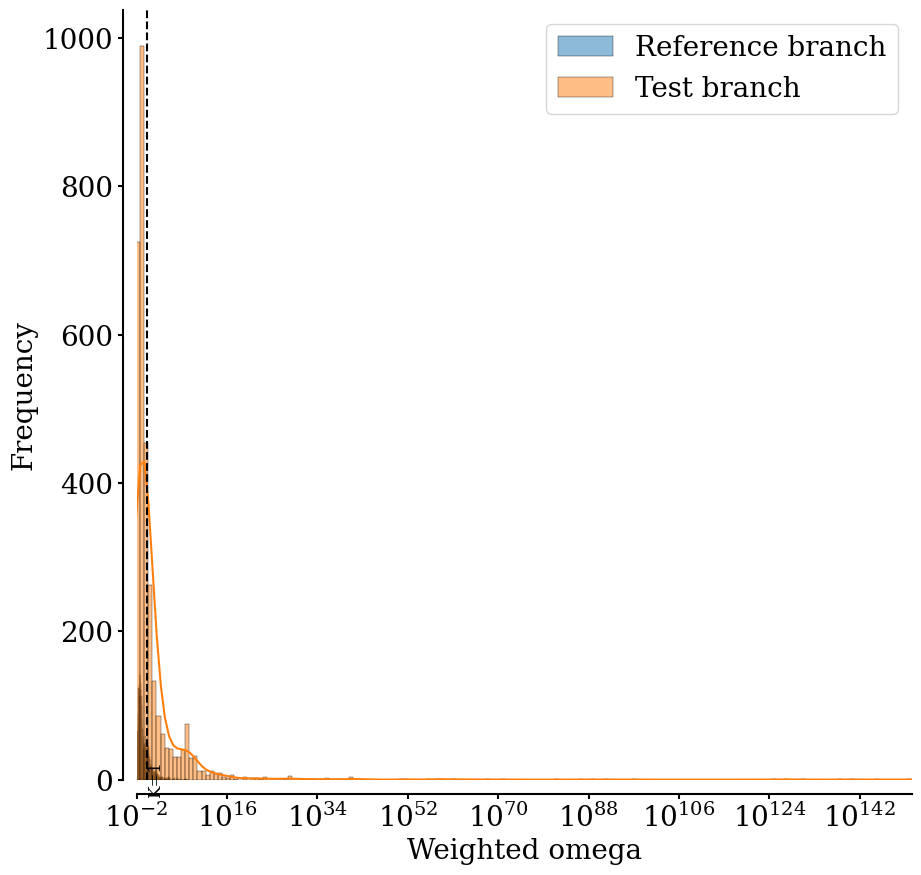

In [11]:
from scipy.stats import mannwhitneyu
# find median omega value across omega_1,2,3 columns, for both Reference and test branches

# fill nan values with 0
relax_flat_fg_df = relax_flat_fg_df.fillna(0)

# replace the omega values that are 9999999171.596359 with 1.0
for col in relax_flat_fg_df.columns:
    relax_flat_fg_df[col] = relax_flat_fg_df[col].replace(9999999171.596359, 1.0)

# first find weighted omega_0 based on omega_0 and proportion of sites for omega_0
relax_flat_fg_df['fg|RELAX alternative|Reference|0|weighted_omega'] = relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] * relax_flat_fg_df['fg|RELAX alternative|Reference|0|proportion']
relax_flat_fg_df['fg|RELAX alternative|Test|0|weighted_omega'] = relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] * relax_flat_fg_df['fg|RELAX alternative|Test|0|proportion']
relax_flat_fg_df['fg|RELAX alternative|Reference|1|weighted_omega'] = relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] * relax_flat_fg_df['fg|RELAX alternative|Reference|1|proportion']
relax_flat_fg_df['fg|RELAX alternative|Test|1|weighted_omega'] = relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] * relax_flat_fg_df['fg|RELAX alternative|Test|1|proportion']
relax_flat_fg_df['fg|RELAX alternative|Reference|2|weighted_omega'] = relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] * relax_flat_fg_df['fg|RELAX alternative|Reference|2|proportion']
relax_flat_fg_df['fg|RELAX alternative|Test|2|weighted_omega'] = relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] * relax_flat_fg_df['fg|RELAX alternative|Test|2|proportion']

# now combine the weighted omegas (0,1,2) for Reference
relax_flat_fg_df['fg|RELAX alternative|Reference|weighted_omega'] = (
    relax_flat_fg_df[['fg|RELAX alternative|Reference|0|weighted_omega',
                      'fg|RELAX alternative|Reference|1|weighted_omega',
                      'fg|RELAX alternative|Reference|2|weighted_omega']].mean(axis=1)
)
relax_flat_fg_df['fg|RELAX alternative|Test|weighted_omega'] = (
    relax_flat_fg_df[['fg|RELAX alternative|Test|0|weighted_omega',
                      'fg|RELAX alternative|Test|1|weighted_omega',
                      'fg|RELAX alternative|Test|2|weighted_omega']].mean(axis=1)
)
# now find the median omega value across the weighted omegas for Reference and Test
print(f"Median omega for Reference branch: {relax_flat_fg_df['fg|RELAX alternative|Reference|weighted_omega'].median()}")
print(f"Median omega for Test branch: {relax_flat_fg_df['fg|RELAX alternative|Test|weighted_omega'].median()}")

# mann-whitney U test to compare the distributions of omega values for Reference and Test branches
u_stat, p_value = mannwhitneyu(relax_flat_fg_df['fg|RELAX alternative|Reference|weighted_omega'], 
                               relax_flat_fg_df['fg|RELAX alternative|Test|weighted_omega'], 
                               alternative='greater')
print(f'Mann-Whitney U test statistic: {u_stat}, p-value: {p_value}')
if p_value < 0.05:
    print('The distributions of omega values for Reference and Test branches are significantly different.')

# print number and percentage of omega_ref and omega_test values that are greater than 1
# aka omega_2 for Reference and Test branches
omega_ref_greater_than_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] > 1).sum()
omega_test_greater_than_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] > 1).sum()
total_ogs = len(relax_flat_fg_df)
print(f'Number of OGs with omega_2 > 1 for Reference branch: {omega_ref_greater_than_1} out of {total_ogs}, which is {omega_ref_greater_than_1 / total_ogs * 100:.2f}%')
print(f'Number of OGs with omega_2 > 1 for Test branch: {omega_test_greater_than_1} out of {total_ogs}, which is {omega_test_greater_than_1 / total_ogs * 100:.2f}%')

# plot these two distributions - same histogram with kde
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(relax_flat_fg_df['fg|RELAX alternative|Reference|weighted_omega'], bins=200, kde=True,
             log_scale=(True, False), ax=ax,
             label='Reference branch')
sns.histplot(relax_flat_fg_df['fg|RELAX alternative|Test|weighted_omega'], bins=200, kde=True,
             log_scale=(True, False), ax=ax,
             label='Test branch')
# K=1 line
ax.axvline(1, color='black', linestyle='--')
# annotate K=1 line with vertical text aligned left and centered
ax.annotate('K=1', 
            # position text based on data coordinates
            xy=(1.05, 0.5),
            xycoords='data',
            fontsize=12, color='black', rotation=90,
            va='center', ha='left',
            )
ax.set_xlabel('Weighted omega')
ax.set_ylabel('Frequency')
ax.legend()
# Tufte style
# top and right spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# left and bottom spines thicker
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
# ticks thicker
ax.tick_params(width=1.5)
# spine bounds = data bounds
ax.set_xlim(left=0.01, right=relax_flat_fg_df[['fg|RELAX alternative|Reference|weighted_omega', 'fg|RELAX alternative|Test|weighted_omega']].max().max() * 1.1)
# ax.set_ylim(bottom=0.01, top=relax_flat_fg_df[['fg|RELAX alternative|Reference|weighted_omega', 'fg|RELAX alternative|Test|weighted_omega']].values.max() * 1.1)
# let axes breathe by moving them away from the data
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.show()

/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


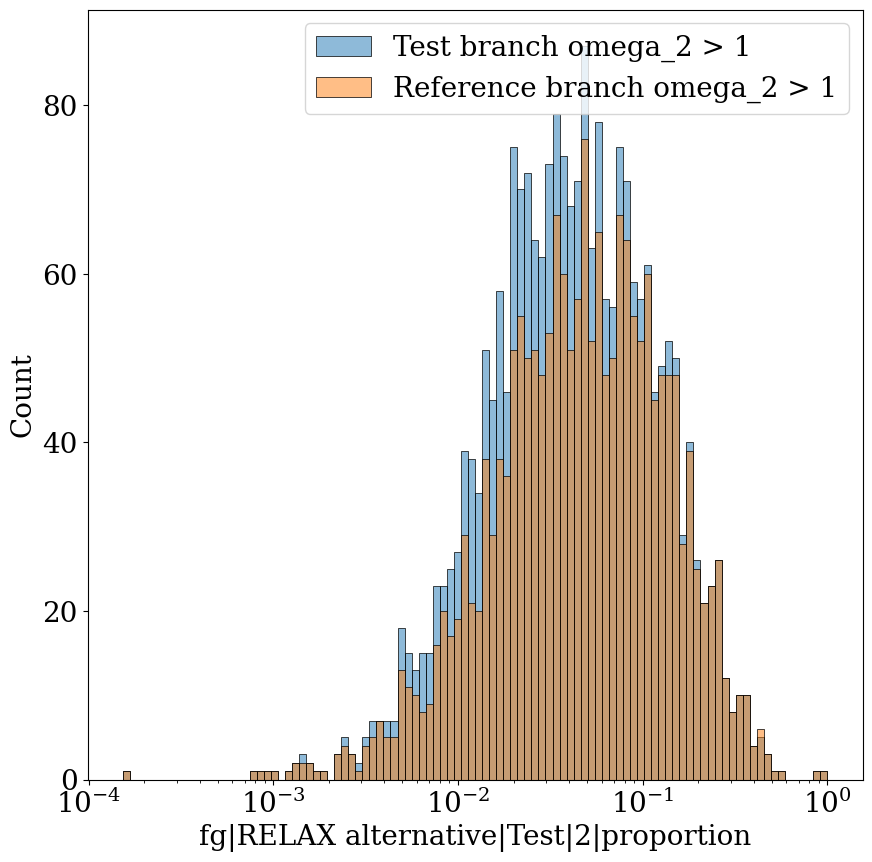

/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


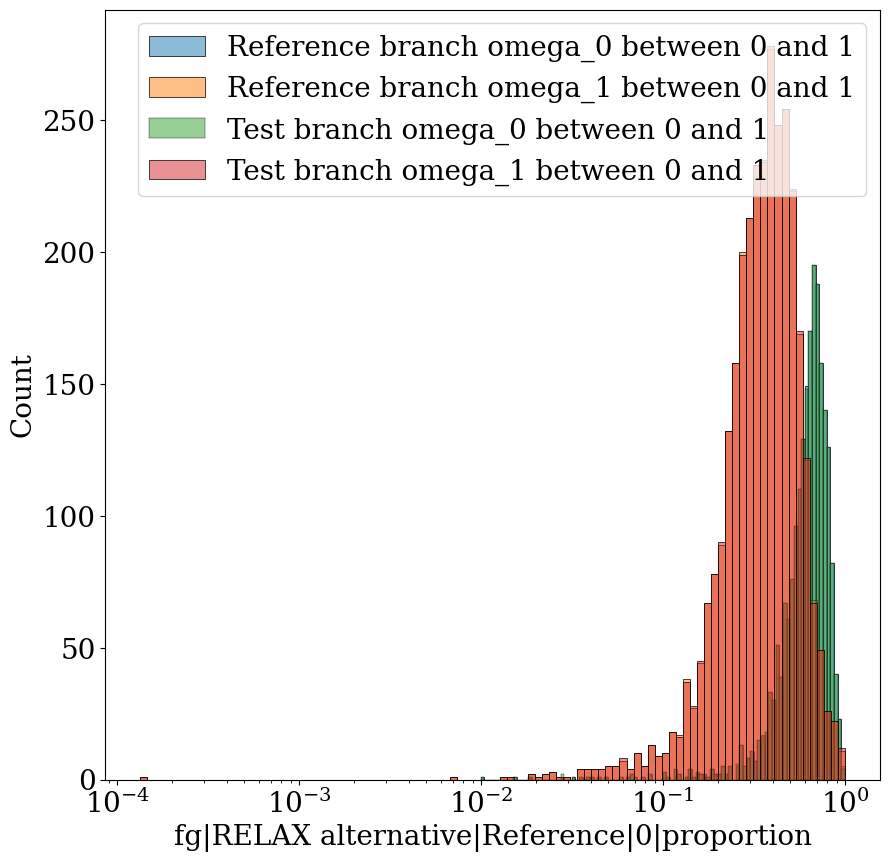

/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


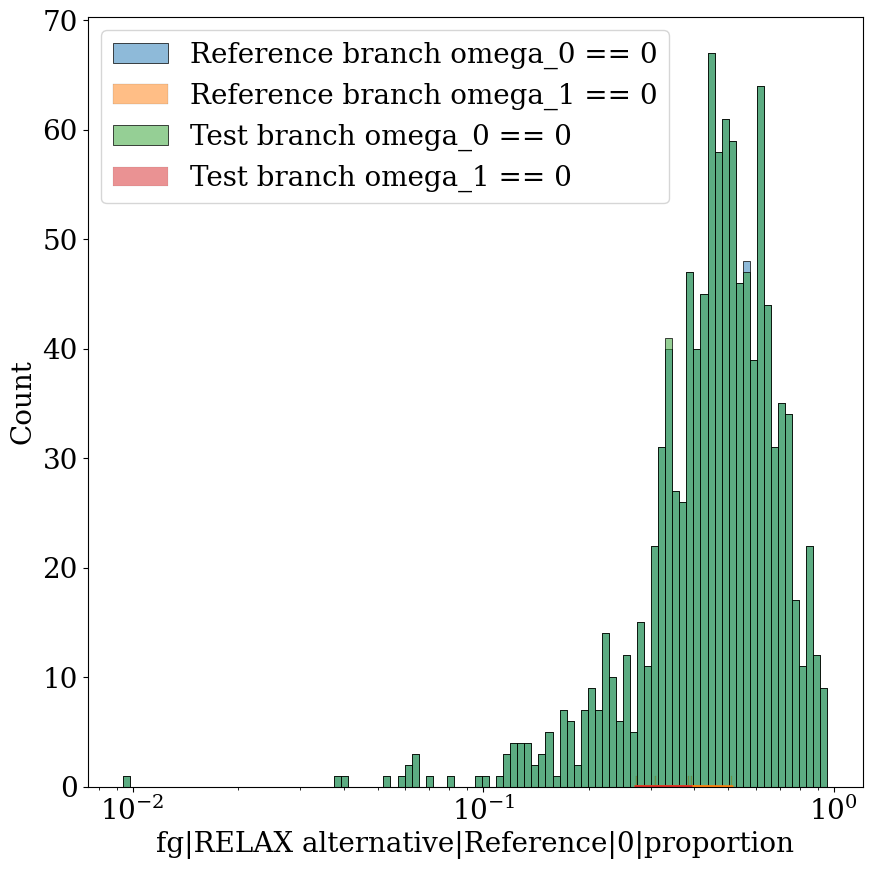

In [12]:
# across Reference omega_0,1,2, if any of the omegas are greater than 1, plot the distribution of the corresponding proportions
fig, ax = plt.subplots(figsize=(10, 10))

sns.histplot(relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] > 1]['fg|RELAX alternative|Test|2|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Test branch omega_2 > 1')
sns.histplot(relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] > 1]['fg|RELAX alternative|Reference|2|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Reference branch omega_2 > 1')

plt.legend()
plt.show()

# similarly for omegas between 0 and 1 but neither 0 or 1
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] > 0) & (relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] < 1)]['fg|RELAX alternative|Reference|0|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Reference branch omega_0 between 0 and 1')
sns.histplot(relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] > 0) & (relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] < 1)]['fg|RELAX alternative|Reference|1|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Reference branch omega_1 between 0 and 1')

sns.histplot(relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] > 0) & (relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] < 1)]['fg|RELAX alternative|Test|0|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Test branch omega_0 between 0 and 1')
sns.histplot(relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] > 0) & (relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] < 1)]['fg|RELAX alternative|Test|1|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Test branch omega_1 between 0 and 1')

plt.legend()
plt.show()

# similarly for omega_0 or omega_1 ==0
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] == 0]['fg|RELAX alternative|Reference|0|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Reference branch omega_0 == 0')
sns.histplot(relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] == 0]['fg|RELAX alternative|Reference|1|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Reference branch omega_1 == 0')
sns.histplot(relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] == 0]['fg|RELAX alternative|Test|0|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Test branch omega_0 == 0')
sns.histplot(relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] == 0]['fg|RELAX alternative|Test|1|proportion'], bins=100, kde=True,
             log_scale=(True, False), ax=ax,
             label='Test branch omega_1 == 0')

# show the plots
plt.legend()
plt.show()

In [13]:
# what percentage of OGs have any of omega_0,1,2 > 1 with the corresponding proportion > 0.5
omega_0_gt_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] > 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|0|proportion'] > 0.5)
omega_1_gt_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] > 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|1|proportion'] > 0.5)
omega_2_gt_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] > 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|2|proportion'] > 0.5)
total_gt_1 = (omega_0_gt_1 | omega_1_gt_1 | omega_2_gt_1).sum()
total_ogs = len(relax_flat_fg_df)
print(f'Number of OGs with any of omega_0,1,2 > 1 with the corresponding proportion > 0.5: {total_gt_1} out of {total_ogs}, which is {total_gt_1 / total_ogs * 100:.2f}%')

# what is the median proportion of sites with any of omega_0,1,2 > 1
test_array_proportion_0_gt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] > 1]['fg|RELAX alternative|Test|0|proportion'].values
test_array_proportion_1_gt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] > 1]['fg|RELAX alternative|Test|1|proportion'].values
test_array_proportion_2_gt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] > 1]['fg|RELAX alternative|Test|2|proportion'].values
test_array_prop_gt_1 = np.concatenate([test_array_proportion_0_gt_1, test_array_proportion_1_gt_1, test_array_proportion_2_gt_1])
test_median_prop_gt_1 = np.median(test_array_prop_gt_1)
print(f'Median proportion of sites with any of omega_0,1,2 > 1: {test_median_prop_gt_1:.4f}')


# similar for omega <1
omega_0_lt_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] < 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|0|proportion'] > 0.5)
omega_1_lt_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] < 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|1|proportion'] > 0.5)
omega_2_lt_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] < 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|2|proportion'] > 0.5)
test_total_lt_1 = (omega_0_lt_1 | omega_1_lt_1 | omega_2_lt_1).sum()
print(f'Number of OGs with any of omega_0,1,2 < 1 with the corresponding proportion > 0.5: {test_total_lt_1} out of {total_ogs}, which is {test_total_lt_1 / total_ogs * 100:.2f}%')

# what is the median proportion of sites with any of omega_0,1,2 < 1
test_array_proportion_0_lt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] < 1]['fg|RELAX alternative|Test|0|proportion'].values
test_array_proportion_1_lt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] < 1]['fg|RELAX alternative|Test|1|proportion'].values
test_array_proportion_2_lt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] < 1]['fg|RELAX alternative|Test|2|proportion'].values
test_array_prop_lt_1 = np.concatenate([test_array_proportion_0_lt_1, test_array_proportion_1_lt_1, test_array_proportion_2_lt_1])
test_median_prop_lt_1 = np.median(test_array_prop_lt_1)
print(f'Median proportion of sites with any of omega_0,1,2 < 1: {test_median_prop_lt_1:.4f}')

# and omega=1
omega_0_eq_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] == 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|0|proportion'] > 0.5)
omega_1_eq_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] == 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|1|proportion'] > 0.5)
omega_2_eq_1 = (relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] == 1) & (relax_flat_fg_df['fg|RELAX alternative|Test|2|proportion'] > 0.5)
total_eq_1 = (omega_0_eq_1 | omega_1_eq_1 | omega_2_eq_1).sum()
print(f'Number of OGs with any of omega_0,1,2 = 1 with the corresponding proportion > 0.5: {total_eq_1} out of {total_ogs}, which is {total_eq_1 / total_ogs * 100:.2f}%')

# what is the median proportion of sites with any of omega_0,1,2 = 1
test_array_proportion_0_eq_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|0|omega'] == 1]['fg|RELAX alternative|Test|0|proportion'].values
test_array_proportion_1_eq_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|1|omega'] == 1]['fg|RELAX alternative|Test|1|proportion'].values
test_array_proportion_2_eq_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Test|2|omega'] == 1]['fg|RELAX alternative|Test|2|proportion'].values
test_array_prop_eq_1 = np.concatenate([test_array_proportion_0_eq_1, test_array_proportion_1_eq_1, test_array_proportion_2_eq_1])
test_median_prop_eq_1 = np.median(test_array_prop_eq_1)
print(f'Median proportion of sites with any of omega_0,1,2 = 1: {test_median_prop_eq_1:.4f}')

Number of OGs with any of omega_0,1,2 > 1 with the corresponding proportion > 0.5: 4 out of 3228, which is 0.12%
Median proportion of sites with any of omega_0,1,2 > 1: 0.0319
Number of OGs with any of omega_0,1,2 < 1 with the corresponding proportion > 0.5: 2805 out of 3228, which is 86.90%
Median proportion of sites with any of omega_0,1,2 < 1: 0.4652
Number of OGs with any of omega_0,1,2 = 1 with the corresponding proportion > 0.5: 2 out of 3228, which is 0.06%
Median proportion of sites with any of omega_0,1,2 = 1: 0.0783


In [14]:
# what percentage of OGs have any of omega_0,1,2 > 1 with the corresponding proportion > 0.5
omega_0_gt_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] > 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|0|proportion'] > 0.5)
omega_1_gt_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] > 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|1|proportion'] > 0.5)
omega_2_gt_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] > 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|2|proportion'] > 0.5)
total_gt_1 = (omega_0_gt_1 | omega_1_gt_1 | omega_2_gt_1).sum()
total_ogs = len(relax_flat_fg_df)
print(f'Number of OGs with any of omega_0,1,2 > 1 with the corresponding proportion > 0.5: {total_gt_1} out of {total_ogs}, which is {total_gt_1 / total_ogs * 100:.2f}%')

# what is the median proportion of sites with any of omega_0,1,2 > 1
ref_array_proportion_0_gt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] > 1]['fg|RELAX alternative|Reference|0|proportion'].values
ref_array_proportion_1_gt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] > 1]['fg|RELAX alternative|Reference|1|proportion'].values
ref_array_proportion_2_gt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] > 1]['fg|RELAX alternative|Reference|2|proportion'].values
ref_array_prop_gt_1 = np.concatenate([ref_array_proportion_0_gt_1, ref_array_proportion_1_gt_1, ref_array_proportion_2_gt_1])
ref_median_prop_gt_1 = np.median(ref_array_prop_gt_1)
print(f'Median proportion of sites with any of omega_0,1,2 > 1: {ref_median_prop_gt_1:.4f}')


# similar for omega <1
omega_0_lt_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] < 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|0|proportion'] > 0.5)
omega_1_lt_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] < 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|1|proportion'] > 0.5)
omega_2_lt_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] < 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|2|proportion'] > 0.5)
ref_total_lt_1 = (omega_0_lt_1 | omega_1_lt_1 | omega_2_lt_1).sum()
print(f'Number of OGs with any of omega_0,1,2 < 1 with the corresponding proportion > 0.5: {ref_total_lt_1} out of {total_ogs}, which is {ref_total_lt_1 / total_ogs * 100:.2f}%')

# what is the median proportion of sites with any of omega_0,1,2 < 1
ref_array_proportion_0_lt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] < 1]['fg|RELAX alternative|Reference|0|proportion'].values
ref_array_proportion_1_lt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] < 1]['fg|RELAX alternative|Reference|1|proportion'].values
ref_array_proportion_2_lt_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] < 1]['fg|RELAX alternative|Reference|2|proportion'].values
ref_array_prop_lt_1 = np.concatenate([ref_array_proportion_0_lt_1, ref_array_proportion_1_lt_1, ref_array_proportion_2_lt_1])
ref_median_prop_lt_1 = np.median(ref_array_prop_lt_1)
print(f'Median proportion of sites with any of omega_0,1,2 < 1: {ref_median_prop_lt_1:.4f}')

# and omega=1
omega_0_eq_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] == 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|0|proportion'] > 0.5)
omega_1_eq_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] == 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|1|proportion'] > 0.5)
omega_2_eq_1 = (relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] == 1) & (relax_flat_fg_df['fg|RELAX alternative|Reference|2|proportion'] > 0.5)
total_eq_1 = (omega_0_eq_1 | omega_1_eq_1 | omega_2_eq_1).sum()
print(f'Number of OGs with any of omega_0,1,2 = 1 with the corresponding proportion > 0.5: {total_eq_1} out of {total_ogs}, which is {total_eq_1 / total_ogs * 100:.2f}%')

# what is the median proportion of sites with any of omega_0,1,2 = 1
ref_array_proportion_0_eq_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|0|omega'] == 1]['fg|RELAX alternative|Reference|0|proportion'].values
ref_array_proportion_1_eq_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|1|omega'] == 1]['fg|RELAX alternative|Reference|1|proportion'].values
ref_array_proportion_2_eq_1 = relax_flat_fg_df[relax_flat_fg_df['fg|RELAX alternative|Reference|2|omega'] == 1]['fg|RELAX alternative|Reference|2|proportion'].values
ref_array_prop_eq_1 = np.concatenate([ref_array_proportion_0_eq_1, ref_array_proportion_1_eq_1, ref_array_proportion_2_eq_1])
ref_median_prop_eq_1 = np.median(ref_array_prop_eq_1)
print(f'Median proportion of sites with any of omega_0,1,2 = 1: {ref_median_prop_eq_1:.4f}')


Number of OGs with any of omega_0,1,2 > 1 with the corresponding proportion > 0.5: 4 out of 3228, which is 0.12%
Median proportion of sites with any of omega_0,1,2 > 1: 0.0344
Number of OGs with any of omega_0,1,2 < 1 with the corresponding proportion > 0.5: 2806 out of 3228, which is 86.93%
Median proportion of sites with any of omega_0,1,2 < 1: 0.4653
Number of OGs with any of omega_0,1,2 = 1 with the corresponding proportion > 0.5: 1 out of 3228, which is 0.03%
Median proportion of sites with any of omega_0,1,2 = 1: 0.0474


In [15]:
# mann-whitney U test to compare the distributions of proportions for Reference and Test branches
# add 0s to the arrays to make the lengths equal and equal to the length of the total_ogs
test_array_prop_gt_1_adj = np.pad(test_array_prop_gt_1, (0, total_ogs - len(test_array_prop_gt_1)), 'constant', constant_values=0)
ref_array_prop_gt_1_adj = np.pad(ref_array_prop_gt_1, (0, total_ogs - len(ref_array_prop_gt_1)), 'constant', constant_values=0)

# print medians now for both arrays
print(f'Median proportion of sites with omega > 1 for Test branch: {np.median(test_array_prop_gt_1_adj):.4f}')
print(f'Median proportion of sites with omega > 1 for Reference branch: {np.median(ref_array_prop_gt_1_adj):.4f}')

u_stat, p_value = mannwhitneyu(test_array_prop_gt_1_adj, 
                               ref_array_prop_gt_1_adj, 
                               alternative='two-sided')

print(f'Number of OGs: {len(test_array_prop_gt_1_adj)} for Test branch, {len(ref_array_prop_gt_1_adj)} for Reference branch')
if p_value < 0.05:
    print('The distributions of proportions for Reference and Test branches are significantly different.')
print(f'Mann-Whitney U test statistic: {u_stat}, p-value: {p_value}')

Median proportion of sites with omega > 1 for Test branch: 0.0240
Median proportion of sites with omega > 1 for Reference branch: 0.0163
Number of OGs: 3228 for Test branch, 3228 for Reference branch
The distributions of proportions for Reference and Test branches are significantly different.
Mann-Whitney U test statistic: 5709953.5, p-value: 9.716886504301351e-12


In [16]:
# find median proportion of sites with omega < 1 for Test and Reference branches
test_array_prop_lt_1_adj = np.pad(test_array_prop_lt_1, (0, total_ogs - test_total_lt_1), 'constant', constant_values=0)
ref_array_prop_lt_1_adj = np.pad(ref_array_prop_lt_1, (0, total_ogs - ref_total_lt_1), 'constant', constant_values=0)
print(f'Median proportion of sites with omega < 1 for Test branch: {np.median(test_array_prop_lt_1_adj):.4f}')
print(f'Median proportion of sites with omega < 1 for Reference branch: {np.median(ref_array_prop_lt_1_adj):.4f}')
u_stat, p_value = mannwhitneyu(test_array_prop_lt_1_adj, 
                               ref_array_prop_lt_1_adj, 
                               alternative='two-sided')
print(f'Number of OGs: {len(test_array_prop_lt_1_adj)} for Test branch, {len(ref_array_prop_lt_1_adj)} for Reference branch')
if p_value < 0.05:
    print('The distributions of proportions for Reference and Test branches are significantly different.')
print(f'Mann-Whitney U test statistic: {u_stat}, p-value: {p_value}')

Median proportion of sites with omega < 1 for Test branch: 0.4461
Median proportion of sites with omega < 1 for Reference branch: 0.4462
Number of OGs: 6821 for Test branch, 6819 for Reference branch
Mann-Whitney U test statistic: 23246348.5, p-value: 0.9658236428732716


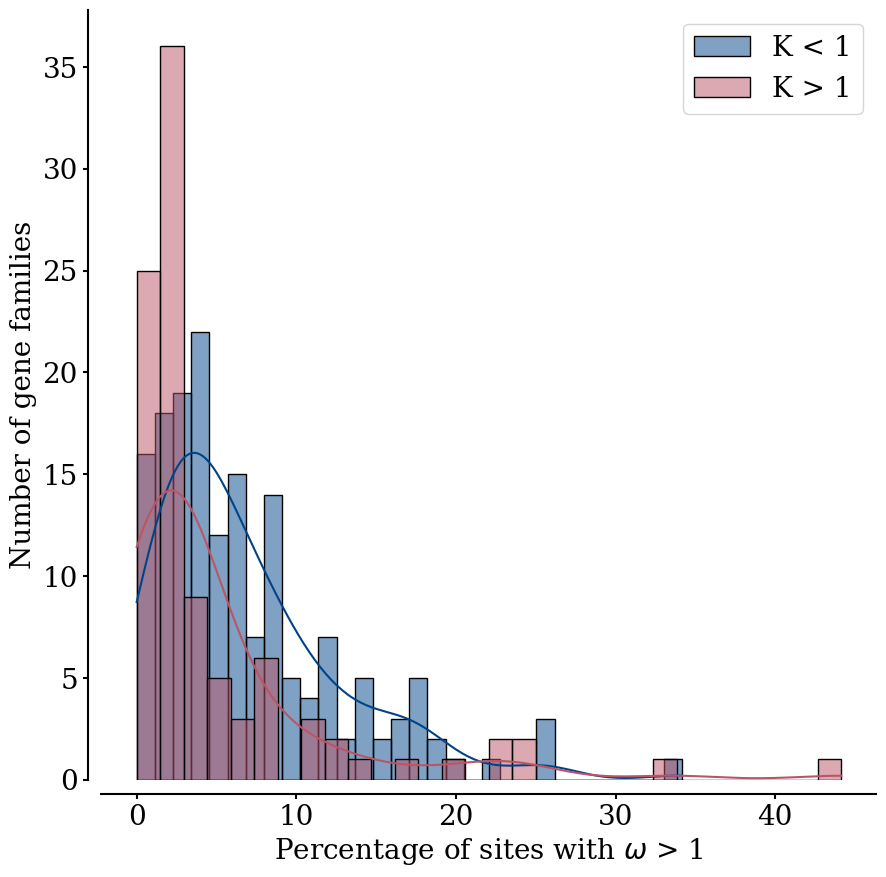

In [19]:
# for K>1 and K<1, plot the proportions of sites with omega > 1
# in the same figure
fig, ax = plt.subplots(figsize=(10, 10))

# first convert proportions to percentages
relax_flat_fg_df['fg|RELAX alternative|Test|2|percentage'] = relax_flat_fg_df['fg|RELAX alternative|Test|2|proportion'] * 100
relax_flat_fg_df['fg|RELAX alternative|Reference|2|percentage'] = relax_flat_fg_df['fg|RELAX alternative|Reference|2|proportion'] * 100

# Use Paul Tol's color palette for dark blue and red
tol_dark_blue = "#004488"
tol_red = "#BB5566"

sns.histplot(
    relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX test|p-value FDR'] < 0.05) & (relax_flat_fg_df['fg|RELAX test|K'] < 1)]['fg|RELAX alternative|Test|2|percentage'],
    bins=30, kde=True, ax=ax, label='K < 1', color=tol_dark_blue
)
sns.histplot(
    relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX test|p-value FDR'] < 0.05) & (relax_flat_fg_df['fg|RELAX test|K'] > 1)]['fg|RELAX alternative|Test|2|percentage'],
    bins=30, kde=True, ax=ax, label='K > 1', color=tol_red
)
plt.legend()
ax.set_xlabel('Percentage of sites with ' + r'$\omega$ > 1')
ax.set_ylabel('Number of gene families')
# Tufte style
# top and right spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# left and bottom spines thicker
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
# ticks thicker
ax.tick_params(width=1.5)
# spine bounds = data bounds
# ax.set_xlim(left=0.01, right=relax_flat_fg_df[['fg|RELAX alternative|Test|2|proportion']].max().max() * 1.1)
# let axes breathe by moving them away from the data
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

# save the figure
plt.savefig(os.path.join(plots_dir, 'histplot_proportions_omega_gt_1_K.png'),
            dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# also do a MWU test to compare the distributions of proportions for K < 1 and K > 1 for omega > 1
k_less_than_1 = relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX test|p-value FDR'] < 0.05) & (relax_flat_fg_df['fg|RELAX test|K'] < 1)]['fg|RELAX alternative|Test|2|percentage'].values
k_greater_than_1 = relax_flat_fg_df[(relax_flat_fg_df['fg|RELAX test|p-value FDR'] < 0.05) & (relax_flat_fg_df['fg|RELAX test|K'] > 1)]['fg|RELAX alternative|Test|2|percentage'].values

print(f'Number of OGs with K < 1: {len(k_less_than_1)}, K > 1: {len(k_greater_than_1)}')
print(f'Median percentage of sites with omega > 1 for K < 1: {np.median(k_less_than_1):.4f}')
print(f'Median percentage of sites with omega > 1 for K > 1: {np.median(k_greater_than_1):.4f}')

mwu_u_stat, mwu_p_value = mannwhitneyu(k_less_than_1, 
                                       k_greater_than_1, 
                                       alternative='two-sided')
print(f'Mann-Whitney U test statistic: {mwu_u_stat}, p-value: {mwu_p_value}')
if mwu_p_value < 0.05:
    print('The distributions of proportions for K < 1 and K > 1 are significantly different.')

Number of OGs with K < 1: 164, K > 1: 98
Median percentage of sites with omega > 1 for K < 1: 5.2000
Median percentage of sites with omega > 1 for K > 1: 2.3738
Mann-Whitney U test statistic: 10653.0, p-value: 1.0399328810174295e-05
The distributions of proportions for K < 1 and K > 1 are significantly different.
